# Gaussian process regression using gpflow

In [1]:
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

from gpflow.config import default_float
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow import set_trainable
from gpflow.utilities import print_summary

import warnings

warnings.filterwarnings("ignore")
gpflow.config.set_default_summary_fmt("notebook")

In [2]:
# Tensorboard (not sure yet what this is supposed to do)
#output_logdir = "/tmp/tensorboard"
#
#!rm -rf "{output_logdir}"
#!mkdir "{output_logdir}"
#
#%load_ext tensorboard
#%matplotlib inline


#def enumerated_logdir(_logdir_id: int = [0]):
#    logdir = pathlib.Path(output_logdir, str(_logdir_id[0]))
#    _logdir_id[0] += 1
#    return str(logdir)

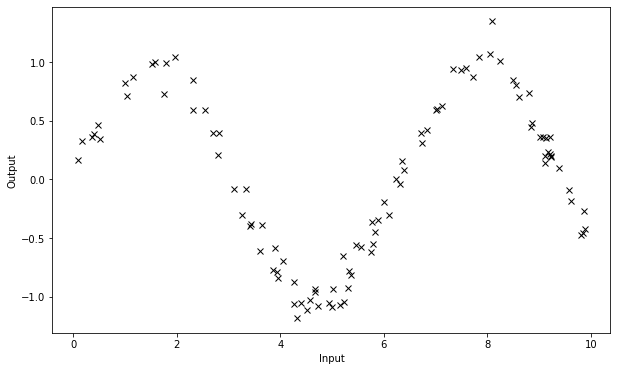

In [3]:
# Creating simple data for a regression task
def noisy_sin(x):
    return tf.math.sin(x) + 0.1 * tf.random.normal(x.shape, dtype=default_float())


num_train_data, num_test_data = 100, 500

X = tf.random.uniform((num_train_data, 1), dtype=default_float()) * 10
Xtest = tf.random.uniform((num_test_data, 1), dtype=default_float()) * 10

Y = noisy_sin(X)
Ytest = noisy_sin(Xtest)

data = (X, Y)

plt.figure(figsize = (10,6))
plt.plot(X, Y, "xk")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

In [4]:
# Example for creating train and test data set (can be used for SVGP for example)
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))

batch_size = 32
num_features = 10
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
# Repeat: does not throw an error if next does not produce new batch
# train_dataset.repeat()
train_dataset = (
    train_dataset.repeat()
    .prefetch(prefetch_size)
    .shuffle(buffer_size=shuffle_buffer_size)
    .batch(batch_size)
)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

prefetch_size=-1
shuffle_buffer_size=50
num_batches_per_epoch=3


In [5]:
# Defining kernel and model
kernel = gpflow.kernels.SquaredExponential(variance=2.0)
likelihood = gpflow.likelihoods.Gaussian()
inducing_variable = np.linspace(0, 10, num_features).reshape(-1, 1)

model = gpflow.models.SVGP(
    kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable
)
set_trainable(likelihood, True)
set_trainable(kernel.variance, True)
kernel.lengthscales.assign(0.5)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-0.43275212956718856>

In [6]:
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.0
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.5
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,Identity,,True,"(10, 1)",float64,[[0....
SVGP.q_mu,Parameter,Identity,,True,"(10, 1)",float64,[[0....
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[1., 0., 0...."


In [7]:
# Data as a tuple
data = (X,Y)

In [8]:
#def optimization_step(model: gpflow.models.SVGP, batch: Tuple[tf.Tensor, tf.Tensor]):
#    with tf.GradientTape(watch_accessed_variables=False) as tape:
#        tape.watch(model.trainable_variables)
#        loss = model.training_loss(batch)
#    grads = tape.gradient(loss, model.trainable_variables)
#    optimizer.apply_gradients(zip(grads, model.trainable_variables))
#    return loss

In [9]:
#def simple_training_loop(model: gpflow.models.SVGP, epochs: int = 1, logging_epoch_freq: int = 10):
#    tf_optimization_step = tf.function(optimization_step)
#
#    batches = iter(train_dataset)
#    for epoch in range(epochs):
#        for _ in range(ci_niter(num_batches_per_epoch)):
#            tf_optimization_step(model, next(batches))
#
#        epoch_id = epoch + 1
#        if epoch_id % logging_epoch_freq == 0:
#            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(data)}")

In [10]:
#simple_training_loop(model, epochs=10, logging_epoch_freq=2)

### Defining model and kernel

In [11]:
kernel = gpflow.kernels.SquaredExponential(variance=2.0)

In [12]:
X_visual = tf.expand_dims(tf.linspace(-3, 3, 50),-1)

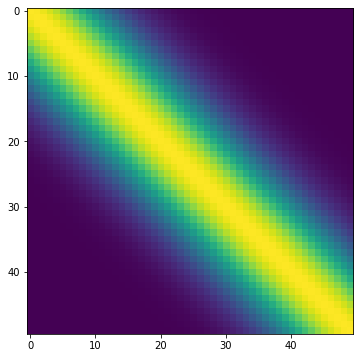

In [13]:
# Visualizing gaussian kernel (before optimization)
plt.figure(figsize = (6,6))
plt.imshow(kernel(X_visual).numpy())
plt.show()

In [14]:
model = gpflow.models.GPR(data = data, kernel = kernel) # We use the data generated earlier
optimizer = tf.optimizers.Adam(lr = 0.01)

In [15]:
model # trainable values 2,1,1

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,2
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


In [16]:
# Let's try to optimize the model
def optimization_step(model: gpflow.models.GPR):
    with tf.GradientTape(watch_accessed_variables=False) as tape: # Controlling which variables are watched
        tape.watch(model.trainable_variables)
        loss = model.training_loss()
    grads = tape.gradient(loss, model.trainable_variables) # first argument the function, second w.r.t
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def simple_training_loop(model: gpflow.models.GPR, epochs: int = 1, logging_epoch_freq: int = 10):
    tf_optimization_step = tf.function(optimization_step)

    #batches = iter(train_dataset)
    for epoch in range(epochs):
        tf_optimization_step(model)

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            tf.print(f"Epoch {epoch_id}: MLL (train) {model.log_marginal_likelihood()}")

In [17]:
simple_training_loop(model, 100, 10)

Epoch 10: MLL (train) -102.85029967296691
Epoch 20: MLL (train) -99.29785086366462
Epoch 30: MLL (train) -95.68636847058083
Epoch 40: MLL (train) -92.011064811228
Epoch 50: MLL (train) -88.26940382388773
Epoch 60: MLL (train) -84.46096398958561
Epoch 70: MLL (train) -80.5869500736558
Epoch 80: MLL (train) -76.64963951550712
Epoch 90: MLL (train) -72.65189596868005
Epoch 100: MLL (train) -68.59677051831414


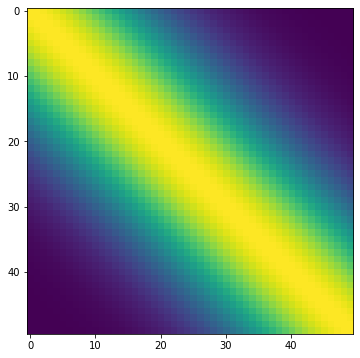

In [18]:
# Visualizing gaussian kernel (after optimization)
plt.figure(figsize = (6,6))
plt.imshow(model.kernel(X_visual).numpy())
plt.show()

In [19]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.2731
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.5988
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.47372


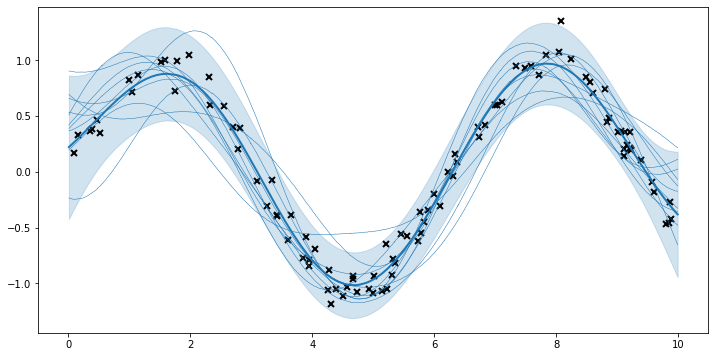

In [20]:
# Plot results
## predict mean and variance of latent GP at test points
sorted_Xtest = sorted(Xtest)
mean, var =  model.predict_f(tf.convert_to_tensor(sorted_Xtest))

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = model.predict_f_samples(tf.convert_to_tensor(sorted_Xtest), 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.plot(tf.convert_to_tensor(sorted_Xtest), mean, "C0", lw=2)
plt.fill_between(
    tf.convert_to_tensor(sorted_Xtest)[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)

plt.plot(tf.convert_to_tensor(sorted_Xtest), samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
plt.show()

## Gaussian process regression for wine-quality dataset

In [21]:
import numpy as np

In [22]:
### load redwine dataset, 11 covariates, 1 output, 1599 datapoints
red_path = '../data/wine/winequality-red.csv'
white_path = '../data/wine/winequality-white.csv'

from numpy import genfromtxt
data = genfromtxt(red_path, delimiter=';')
indices = np.random.permutation(data[1:].shape[0])
training_idx, test_idx = indices[:int(0.8*1599)], indices[int(0.8*1599):]

In [23]:
# standardize each covariate to mean 0 var 1
Xnp = data[1:,0:-1]
Xnp -= np.mean(Xnp)
Xnp /= np.std(Xnp)

# scale outputs to [0,1]
ynp = data[1:,-1]
ynp = (ynp - np.min(ynp)) / (np.max(ynp) - np.min(ynp))

train_Xnp, test_Xnp = Xnp[training_idx], Xnp[test_idx]
train_ynp, test_ynp = ynp[training_idx], ynp[test_idx]

In [24]:
train_Xnp = tf.convert_to_tensor(train_Xnp)
train_ynp = tf.convert_to_tensor(train_ynp)
train_ynp = tf.expand_dims(train_ynp, -1)

In [25]:
data = (train_Xnp, train_ynp)

In [26]:
kernel = gpflow.kernels.SquaredExponential(variance=2.0)
model = gpflow.models.GPR(data = data, kernel = kernel)
optimizer = tf.optimizers.Adam(lr = 0.01)
training_loss = model.training_loss_closure()  # We save the compiled closure in a variable so as not to re-compile it each step

In [27]:
simple_training_loop(model, 1000, 50)

Epoch 50: MLL (train) -1016.050686659848
Epoch 100: MLL (train) -761.8909845562748
Epoch 150: MLL (train) -483.2950816869243
Epoch 200: MLL (train) -195.52658221690467
Epoch 250: MLL (train) 79.93305581295795
Epoch 300: MLL (train) 320.01743271559803
Epoch 350: MLL (train) 505.3426997870961
Epoch 400: MLL (train) 627.3534148993458
Epoch 450: MLL (train) 694.2638886595726
Epoch 500: MLL (train) 725.5292204903199
Epoch 550: MLL (train) 738.7029027871783
Epoch 600: MLL (train) 743.9673571400976
Epoch 650: MLL (train) 746.1948088698846
Epoch 700: MLL (train) 747.4352320093071
Epoch 750: MLL (train) 748.3450250301184
Epoch 800: MLL (train) 749.0980584067618
Epoch 850: MLL (train) 749.7475885143253
Epoch 900: MLL (train) 750.3186257193411
Epoch 950: MLL (train) 750.8272910481355
Epoch 1000: MLL (train) 751.285263968683


In [28]:
mean, var = model.predict_f(tf.convert_to_tensor(test_Xnp))

In [29]:
mean.shape, var.shape

(TensorShape([320, 1]), TensorShape([320, 1]))

In [30]:
test_ynp = tf.convert_to_tensor(test_ynp)
test_ynp = tf.expand_dims(test_ynp, -1)

In [31]:
new_mean = tf.round(mean*10)
test_ynp = test_ynp*10

In [32]:
mis = 0
length = new_mean.shape[0]
for i,j in zip(new_mean, test_ynp):
    if i.numpy() != j.numpy():
        mis += 1

print("Accuracy:", (length - mis) / length)

Accuracy: 0.3125
